# 単眼深度推定モデルを学習する
このノートではいよいよ単眼深度推定モデルの学習を行う。
ここでは簡単のために、最もシンプルなLossとネットワークをもちいて大枠の学習の方法を見ていく。

## ハイパーパラメタ
まずはじめにハイパーパラメタを設定しておく

In [1]:
frame_inds = [0, -1]  # 隣接フレームの番号
epochs = 20
lr = 0.0001
batch_size = 24

## ネットワーク
学習するネットワークは現在のフレームの深度を推定するものと、フレーム間の姿勢の変化を推定するものの２つである。<br>
ここではそれぞれdepth netとpose netと呼ぶ。
depth netは深度マップを推定するネットワークであり、pose netは回転（X軸,Y軸,Z軸）と並進（X,Y,Z）の合計6個の数値を推定するネットワークである。

### depth net
ここではネットワークの詳細に関心はないため、`segmentation_models_pytorch` をつかいU-Netを定義する。

In [2]:
import segmentation_models_pytorch as smp
import torch

depth_net = smp.Unet('resnet18', in_channels=3, classes=1, activation='sigmoid')

# 入出力確認
depth_net(torch.zeros(1, 3, 224, 224))

tensor([[[[0.4789, 0.4683, 0.4197,  ..., 0.4237, 0.3336, 0.5439],
          [0.4507, 0.4806, 0.4149,  ..., 0.1620, 0.2024, 0.4555],
          [0.3887, 0.4733, 0.4054,  ..., 0.0818, 0.2298, 0.3671],
          ...,
          [0.4034, 0.3803, 0.2364,  ..., 0.5683, 0.4504, 0.3231],
          [0.4692, 0.5338, 0.3978,  ..., 0.3762, 0.4307, 0.4349],
          [0.5408, 0.6711, 0.4498,  ..., 0.4236, 0.5351, 0.3465]]]],
       grad_fn=<SigmoidBackward0>)

### pose net

pose netに関してもネットワークの詳細には関心がないため、torchvisionの学習済みモデルを持ってきて、部分的にレイヤーを差し替える。<br>
pose netの入力は現在フレームと隣接フレームの２枚であり、出力はそれらのフレーム間での姿勢の変化量であるため、入力チャンネルは合計で6チャンネルとなる。

In [3]:
from torchvision.models import resnet18
from torch.nn import Linear, Conv2d

pose_net = resnet18(pretrained=True)
pose_net.conv1 = Conv2d(in_channels=3*2, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
pose_net.fc = Linear(in_features=512, out_features=6)

# 入出力確認
pose_net(torch.zeros(1, 3*2, 224, 224)).shape

torch.Size([1, 6])

ネットワークの定義は以上である。

## Loss関数
ここではPhotometric lossとSmoothness lossを定義する。<br>

Photometric lossは推定した深度と姿勢変化からSourceの画像をTargetの画像に重ね合わせて一致しているかどうかをl1 lossで測る。
（l1 lossだけではなく、SSIM lossを加えるのが一般的だが、ここではl1 lossのみとする）
また、Monodepth2で提案されたOcculusion、動く物体等の不都合な物体に対するLossの計算を回避するauto-maskingを導入した。

Smoothness lossはPhotometric lossの復元誤差が濃淡が平滑な領域で勾配を得にくいという問題を解消するために、隣接するピクセルの深度が近いという事前知識を導入する。
Smoothness lossの実装は様々あるが、ここではX,Y方向の差分のみから計算する比較的にシンプルなものを用いる。

In [4]:
import sys
sys.path.append("../../src")

In [5]:
import torch.nn.functional as F
from camera import PinholeCamera
from functools import lru_cache

class PhotometricLoss(torch.nn.Module):
    def __init__(self, frame_inds):
        super().__init__()
        self.frame_inds = frame_inds
        self.l1_loss = torch.nn.L1Loss(reduction="none")

    def forward(self, y, y_pred):
        image_target = y["rgb_0"]
        depth = y_pred[f"depth_0"]
        intrinsic = y["intrinsic_0"]

        reproj_loss = []
        for idx in self.frame_inds:
            if idx == 0: # don't compare target with target
                continue
            image_source = y[f"rgb_{idx}"]
            extrinsic_src2tgt = y_pred[f"extrinsic_{idx}"]
            image_warped = self.warp(image_source, depth, intrinsic, extrinsic_src2tgt)
            reproj_loss_ = self.l1_loss(image_warped, image_target)
            reproj_loss_ = torch.mean(reproj_loss_, dim=1) # compute mean at channel axis
            reproj_loss.append(reproj_loss_)

        # auto-masking (https://arxiv.org/pdf/1806.01260.pdf) using non warped image
        for idx in self.frame_inds:
            if idx == 0: # don't compare target with target
                continue
            image_source = y[f"rgb_{idx}"]
            reproj_loss_ = self.l1_loss(image_source, image_target)
            reproj_loss_ = torch.mean(reproj_loss_, dim=1) # compute mean at channel axis
            reproj_loss.append(reproj_loss_)
        
        reproj_loss = torch.stack(reproj_loss, dim=1)
        loss, _ = torch.min(reproj_loss, dim=1)
        loss = reproj_loss.mean()
        return loss, image_warped

    def warp(self, image_source, depth, intrinsic, extrinsic_src2tgt):
        image_coords = self.create_image_coords(depth.shape)
        image_coords = image_coords.to(depth.device)
        world_coords = PinholeCamera.image2world(image_coords, intrinsic, extrinsic_src2tgt, depth, batch=True)
        # skip world2camera() because the coord is already camera coords here.
        world_coords = world_coords[..., :3] # remove 4th dim        
        image_coords = PinholeCamera.camera2image(world_coords, intrinsic, batch=True)        
        # normalize the coord to be in [-1, 1] for grid sampling
        image_coords[..., 0] = image_coords[..., 0] / image_coords.shape[2] * 2 - 1
        image_coords[..., 1] = image_coords[..., 1] / image_coords.shape[1] * 2 - 1
        grid = image_coords
        image_warped = F.grid_sample(image_source, grid, align_corners=False)
        return image_warped
                
    @lru_cache(None)
    def create_image_coords(self, map_shape):
        # 以前と同様にmeshgridで画像座標を生成する
        xi = torch.arange(0, map_shape[2], 1)
        yi = torch.arange(0, map_shape[1], 1)
        coord_x, coord_y = torch.meshgrid(xi, yi, indexing="xy")
        image_coords = torch.stack([coord_x, coord_y], axis=-1)
        image_coords = image_coords.float()
        # batch
        image_coords = image_coords.unsqueeze(0).repeat(map_shape[0], 1, 1, 1)
        return image_coords


class SmoothnessLoss(torch.nn.Module):

    def forward(self, y, y_pred):
        depth = y_pred[f"inv_depth_0"]
        gradients_y = torch.mean(torch.abs(inv_depth[..., :-1,  :] - inv_depth[..., 1:,  :]))
        gradients_x = torch.mean(torch.abs(inv_depth[..., :  ,:-1] - inv_depth[...,  :, 1:]))
        return (gradients_x + gradients_y) / 2

In [6]:
photometric_loss = PhotometricLoss(frame_inds=frame_inds)
smoothness_loss = SmoothnessLoss()

## Pose Utils
pose netが推定した姿勢の変化量（6変数）を4x4の行列に変換するユーティリティ関数を定義する。
と思ったが、torchgeometryで提供されている関数が便利だったため、それを使うことにする。

In [7]:
import torchgeometry as tgm

tgm.rtvec_to_pose(torch.rand(3, 6)).shape


torch.Size([3, 4, 4])

## training loop
ここからようやく学習を実行する。<br>
この学習はGTX1060（6GB RAM）で動作することが確認できている。<br>
より大きなRAMを搭載したGPUをつかえばバッチ数、フレーム数（frame_inds）を増やし、学習を安定化させることができるはずである。

In [8]:
from dataset import VKITTI2

train_dataset = VKITTI2(root_dir="../../data")

loading sequences


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


In [9]:
from torch.utils.data import DataLoader, Dataset
import cv2


class Transform(Dataset):
    """
    ネットワークへの入力に適切な形に変換するクラス。
    主に画像のリサイズとそれに伴う内部パラメタの補正を行う。
    """
    def __init__(self, dataset):        
        super().__init__()
        self.dataset = dataset
        self.crop = (45, 43, 1197, 331) # (x0, y0, x1, y1)
        self.scale = 1.0 / 3.0

    def __getitem__(self, idx):
        data = self.dataset[idx]
        for key in data.keys():
            if key.startswith("rgb_") or key.startswith("depth_"):
                # 画像と深度を変換する
                image = data[key]
                # crop
                image = image[self.crop[1]:self.crop[3], self.crop[0]:self.crop[2]]
                orig_shape = image.shape
                dest_size = (int(orig_shape[1] * self.scale), int(orig_shape[0] * self.scale))
                # resize
                image = cv2.resize(image, dest_size, interpolation=cv2.INTER_LINEAR)
                data[key] = torch.tensor(image).float()
                if key.startswith("rgb_"):
                    data[key] = data[key].permute(2, 0, 1) # (B, H, W, C) -> (B, C, H, W)
                    data[key] /= 255.0 # normalize
            elif key.startswith("intrinsic_"):
                # 画像がリサイズとクロップに合わせて内部パラメタを補正する
                intrinsic = data[key]
                intrinsic[0, 2] = intrinsic[0, 2] - self.crop[0]
                intrinsic[1, 2] = intrinsic[1, 2] - self.crop[1]
                intrinsic[:2, :] *= self.scale
                data[key] = intrinsic
            
            data[key] = torch.tensor(data[key]).float()

        return data

    def __len__(self):
        return len(self.dataset)


train_dataloader = DataLoader(Transform(train_dataset), batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/1767 [00:00<?, ?it/s]/home/yudai/monocular_depth_estimation_from_scratch/venv/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


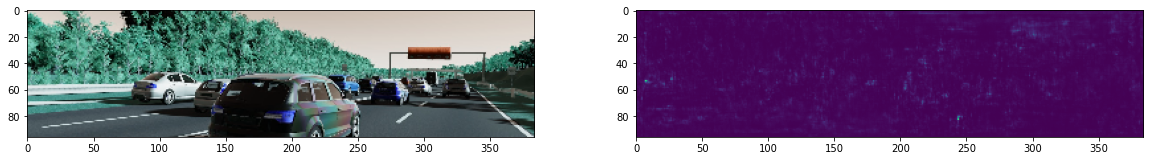

[Epoch 0] loss (ph): 0.103, loss (sm) 0.017, depth mean 10.405, trans mag 3.519:  28%|██▊       | 500/1767 [09:07<23:08,  1.10s/it]

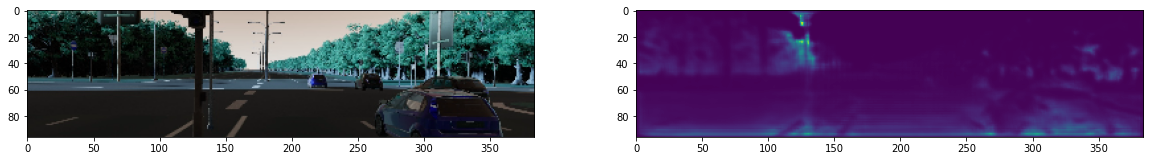

[Epoch 0] loss (ph): 0.119, loss (sm) 0.018, depth mean 12.687, trans mag 4.324:  57%|█████▋    | 1000/1767 [18:17<14:12,  1.11s/it]

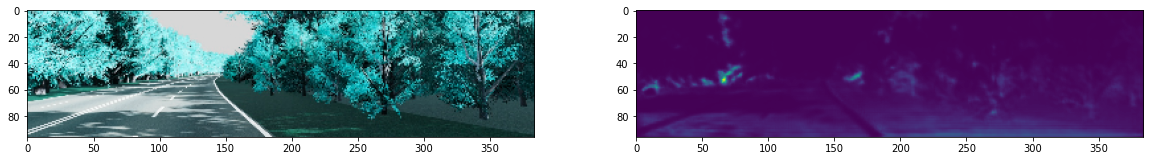

[Epoch 0] loss (ph): 0.087, loss (sm) 0.017, depth mean 10.580, trans mag 4.918:  85%|████████▍ | 1500/1767 [27:32<04:54,  1.10s/it]

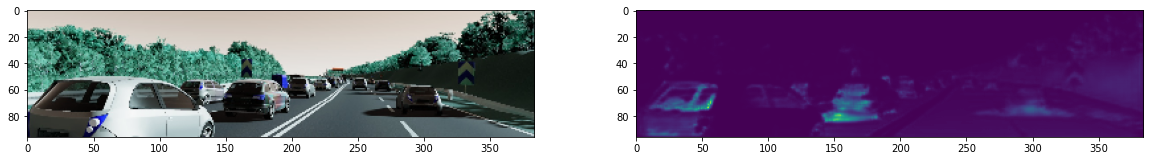

[Epoch 0] loss (ph): 0.102, loss (sm) 0.017, depth mean 9.583, trans mag 4.753:  99%|█████████▉| 1755/1767 [32:15<00:13,  1.11s/it] 

In [10]:
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt


# Single GPU
device="cuda:0"

depth_net.train().to(device)
pose_net.train().to(device)

optimizer = Adam([
    {"params": depth_net.parameters()},
    {"params": pose_net.parameters()}],
    lr=lr)

for i in range(epochs):
    with tqdm(train_dataloader) as pbar:
        for j, batch in enumerate(pbar):
            # transport batch to device
            batch = {k:v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()

            # predict depth
            inv_depth = depth_net(batch["rgb_0"])
            inv_depth = inv_depth.squeeze(1)
            inv_depth = torch.clip(inv_depth, min=0.001, max=1.0)
            depth = 1 / inv_depth

            # predict pose
            image_concat = torch.cat([batch["rgb_0"], batch["rgb_-1"]], axis=1)
            pose = pose_net(image_concat)
            rtmat = tgm.rtvec_to_pose(pose)

            # compute loss
            y = {k:v for k, v in batch.items() if k.startswith("rgb_") or k.startswith("intrinsic_")}
            y_pred = {
                "depth_0": depth,
                "inv_depth_0": inv_depth,
                "extrinsic_-1": rtmat,
            }
            loss_ph, image_warped = photometric_loss(y, y_pred)
            loss_sm = smoothness_loss(y, y_pred)
            loss = (loss_ph * 0.95) + (loss_sm * 0.05)
            loss.backward()
            optimizer.step()

            if j % 500 == 0:
                # pickup first image and depth to show current status
                plt.figure(figsize=(20, 20))
                ax_image = plt.subplot(1, 2, 1)
                ax_depth = plt.subplot(1, 2, 2)
                ax_image.imshow(batch["rgb_0"][0].detach().cpu().numpy().transpose(1, 2, 0))
                ax_depth.imshow(depth[0].detach().cpu().numpy())
                plt.savefig(f"debug/epoch_{i}_iter_{j}_output.jpeg")
                plt.show()                

            # status update
            pbar.set_description(
                f"[Epoch {i}] loss (ph): {loss_ph:0.3f}, " \
                f"loss (sm) {loss_sm:0.3f}, " \
                f"depth mean {depth.mean():0.3f}, " \
                f"trans mag {torch.linalg.vector_norm(pose[..., 3:], ord=2, dim=-1).mean():0.3f}")
